# IAB303 - Assessment 1 - Part B

## Foundational Techniques

#### INSTRUCTIONS

1. Complete the section below with your personal details (and run the cell)
2. Complete the full **QDAVI** data analytics cycle for the provided business concern. Ensure that you complete the cycle by addressing the question with your insights. You may undertake more than one cycle depending on your findings.
3. Ensure that you identify a meaningful question that clearly addresses the business concern.
4. Ensure that you use markdown cells to document your thinking and decision making for each stage of the process. Be clear on how your decisions are working towards addressing the question.
5. Ensure that your code runs without errors, and that your results are appropriate for the question.

In [76]:
# Complete the following cell with your details and run to produce your personalised header for this assignment

from IPython.core.display import display, HTML

first_name = "Cai"
last_name = "Liosatos"
student_number = "n10514295"

personal_header = "<h1>"+first_name+" "+last_name+" ("+student_number+")</h1>"
display(HTML(personal_header))

C:\Users\Cai Liosatos\AppData\Local\Temp\ipykernel_17004\647116755.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---
## BUSINESS CONCERN

Your business is provided intelligence to other companies on global issues and potential impact on consumer spending. They wish to know how media reporting has changed in the last 6 months on (a) the war in Ukraine and (b) global energy and fuel issues.

Using *The Guardian* API, identify relevant headlines (using unstructured data analysis techniques), and then create one or more dataframes which you can use to visualise relevant data (using structured data analysis techniques).

*Hint: You may look at how the frequency of certain words changes over time*

#### Data:
[The Guardian OpenPlatform](https://open-platform.theguardian.com/access/)


In [1]:
# import libraries that you need here
import pandas as pd
import re
import os 
import json
import requests
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


# change this to True if you would like results to be cached (Note: It will create folders and files in the same location as this file is saved)
cache_on = False

### 1. Question

Identify any potential relationships between the following areas in published articles in the media to identify any potential impacts that could be had on consumer spending:
- the war in Ukraine
- global fuel issues
- global energy issues

### 2. Data

Write functions to save pulled data to a cache (if turned on by user), and load data from cached files

In [2]:
# function to create a cached file containing the page pulled from the API
def cache_save(folder_url, current_page, cache_list):
    np.save(folder_url+str(current_page)+".npy", cache_list, allow_pickle=True, fix_imports=True)

# function to load the cached files into a list
def cache_load(folder_url):
# loading cache
    if os.path.exists(folder_url):
        loaded_cache = []
        for file in os.listdir(folder_url):
            loaded_cache.append(np.load(folder_url+file, allow_pickle=True).tolist())
        new_cache_list = flatten_list(loaded_cache)
        return new_cache_list

# function to flatten list of cached lists into a singular list
def flatten_list(cache_list):
    flat_list = []
    # Iterate through the outer list
    for element in cache_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

Scrape data from API (using URL ), and clean up the dataframe to be mroe visually appealing

In [3]:
# calling the api URL to get the total page count
def page_count(api_url_start, api_url_end):
    error_counter = 0
    while error_counter < 3:
        api_url = api_url_start + "1" + api_url_end
        content = requests.get(api_url)
        api_data = json.loads(content.content)
        if api_data['response']['status'] == "ok":
            page_count = int(api_data['response']['pages'])
            break
        else:
            error_counter += 1
    page_count = "API has errored three times in a row whilst trying to get page count, check if the URL is correct" if error_counter >= 3 else page_count
    return page_count

#  function to scrape the data from the page returned from the api into a list
def api_scraping(page_count, url_start, url_end, folder_url):
    error_msg = []
    error_counter = 0
    current_page = 1
    results_list = []
# while loop to add outputs to a list
    while current_page <= page_count:
        if error_counter < 3:
            cache_list = []
            api_url = url_start + str(current_page) + url_end
            content = requests.get(api_url)
            api_data = json.loads(content.content)
            if api_data['response']['status'] == "error":
                error_msg.append(api_data['response']['message'])
                error_counter += 1
            else:
                for item in api_data['response']['results']:
                    cache_list.append(item)
                    results_list.append(item)
        
                # caching results for local use
                if cache_on:
                    cache_save(folder_url, current_page, cache_list)
                current_page += 1
                error_counter = 0
                error_msg = []
        else:
            error_msg.append("API has errored three times in a row, giving up")
            break
    return results_list, error_msg

# Clean up dataframe to be more visually appealing, and easier to use
def df_creation(dataframe_name):
    dataframe_name = dataframe_name.rename(columns = {'id':'ID', 'type':'Type', 'sectionId':'SectionID', 'sectionName':'Section Name', 'webPublicationDate':'Web Publication Date', 'webTitle':'Web Title', 'webUrl':'URL', 'apiUrl':'API URL', 'isHosted':'Is Hosted', 'pillarId': 'Pillar ID', 'pillarName':'Pillar Name'}).copy()
    # clean the data to be more user friendly
    if "Web Publication Date" in dataframe_name.columns:
        dataframe_name["Web Publication Date"] = dataframe_name["Web Publication Date"].apply(lambda x: x.replace("T", " ").replace("Z", ""))
        if dataframe_name["Web Publication Date"].dtype == object:
            dataframe_name["Web Publication Date"] = pd.to_datetime(dataframe_name["Web Publication Date"], format="%Y-%m-%d %H:%M:%S")
        dataframe_name.sort_values(by='Web Publication Date', ascending=False, inplace=True)
        dataframe_name["Month"] = dataframe_name["Web Publication Date"].dt.month
        dataframe_name["Year"] = dataframe_name["Web Publication Date"].dt.year
    if "Pillar ID" in dataframe_name.columns:
        dataframe_name["Pillar ID"] = dataframe_name["Pillar ID"].astype(str).apply(lambda x: x.replace("pillar/", ""))
    
    return dataframe_name

Pull data from the TheGuardian API, with specified URLs, then save to DF (allow about 30 seconds for the data to be completely retrieved)

In [4]:
# setting important variables
ukraine_results = []
ukraine_api_url_start = "https://content.guardianapis.com/search?from-date=2022-02-20&order-by=newest&page="
ukraine_api_url_end = "&page-size=200&q=%22Ukraine%20War%22&api-key=dd3e21c9-be37-4bdb-b311-2fd86c0fd153"

# getting the total page count
ukraine_page_count = page_count(ukraine_api_url_start, ukraine_api_url_end)

# making the cache folder directory
if cache_on:
    if os.path.exists("./cache/Ukraine-War/") is False:
        os.makedirs("./cache/Ukraine-War/")

# printing first result of data if no errors, else printing the error (formatted)
if type(ukraine_page_count) == int:
    ukraine_results, error_msg = api_scraping(ukraine_page_count, ukraine_api_url_start, ukraine_api_url_end, "./cache/fuel-Issues/")
    print(f"{error_msg[3]}\n\nThese were the error messages:\n1: {error_msg[0]}\n2: {error_msg[1]}\n3: {error_msg[2]}\n\nMake sure the URL is correct, then try again") if len(error_msg) > 3 else print(fuel_results[0])
else:
    print(ukraine_page_count)

NameError: name 'fuel_results' is not defined

Load cached files if cache is turned on (turned off currently, can be turned back on at top of file, where data is getting imported)

In [81]:
# loading cache
if cache_on:
    ukraine_results = cache_load("./cache/Ukraine-War/")

In [82]:
# create DF from ukraine_results list
ukraine_api_data_df = pd.DataFrame(ukraine_results)

# Clean/prepare the data for analysis
ukraine_api_data_df = df_creation(ukraine_api_data_df)

ukraine_api_data_df

,ID,Type,SectionID,Section Name,Web Publication Date,Web Title,URL,API URL,Is Hosted,Pillar ID,Pillar Name,Month,Year
0,world/live/2022/sep/01/russia-ukraine-war-no-q...,liveblog,world,World news,2022-09-01 04:27:37,Russia-Ukraine war: No ‘quick wins’ in Kherson...,https://www.theguardian.com/world/live/2022/se...,https://content.guardianapis.com/world/live/20...,False,news,News,9,2022
1,world/2022/sep/01/russia-ukraine-war-latest-wh...,article,world,World news,2022-09-01 01:00:02,Russia-Ukraine war latest: what we know on day...,https://www.theguardian.com/world/2022/sep/01/...,https://content.guardianapis.com/world/2022/se...,False,news,News,9,2022
2,world/live/2022/aug/31/russia-ukraine-war-un-n...,liveblog,world,World news,2022-08-31 18:00:06,Russia-Ukraine war: Moscow could expand confli...,https://www.theguardian.com/world/live/2022/au...,https://content.guardianapis.com/world/live/20...,False,news,News,8,2022
3,world/2022/aug/31/is-it-time-to-abandon-the-nu...,article,world,World news,2022-08-31 17:19:13,Is it time to abandon the nuclear non-prolifer...,https://www.theguardian.com/world/2022/aug/31/...,https://content.guardianapis.com/world/2022/au...,False,news,News,8,2022
4,world/2022/aug/31/russia-ukraine-war-latest-wh...,article,world,World news,2022-08-31 14:48:28,Russia-Ukraine war latest: what we know on day...,https://www.theguardian.com/world/2022/aug/31/...,https://content.guardianapis.com/world/2022/au...,False,news,News,8,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,world/live/2022/feb/24/russia-invades-ukraine-...,liveblog,world,World news,2022-02-25 05:34:58,Fears Moscow plans to encircle and threaten Ky...,https://www.theguardian.com/world/live/2022/fe...,https://content.guardianapis.com/world/live/20...,False,news,News,2,2022
2344,business/live/2022/feb/24/oil-prices-rise-100-...,liveblog,business,Business,2022-02-24 16:51:54,"Oil jumps to $105, gas prices surge and global...",https://www.theguardian.com/business/live/2022...,https://content.guardianapis.com/business/live...,False,news,News,2,2022
2345,world/live/2022/feb/23/ukraine-russia-news-cri...,liveblog,world,World news,2022-02-24 05:57:05,Markets shaken after Putin announces special m...,https://www.theguardian.com/world/live/2022/fe...,https://content.guardianapis.com/world/live/20...,False,news,News,2,2022
2346,world/live/2022/feb/22/ukraine-russia-latest-l...,liveblog,world,World news,2022-02-23 04:59:23,"US, UK and European sanctions target Russian e...",https://www.theguardian.com/world/live/2022/fe...,https://content.guardianapis.com/world/live/20...,False,news,News,2,2022


In [83]:
# same code as before, but for fuel issues

# setting important variables
fuel_results = []
fuel_api_url_start = 'https://content.guardianapis.com/search?from-date=2022-02-20&order-by=newest&page='
fuel_api_url_end = '&page-size=100&q=Fuel%20AND%20Issues&api-key=dd3e21c9-be37-4bdb-b311-2fd86c0fd153'

# getting the total page count
fuel_page_count = page_count(fuel_api_url_start, fuel_api_url_end)


# making the cache folder directory
if cache_on:
    if os.path.exists("./cache/Fuel-Issues/") is False:
        os.makedirs("./cache/Fuel-Issues/")

# printing first result of data if no errors, else printing the error (formatted)
if type(fuel_page_count) == int:
    fuel_results, error_msg = api_scraping(fuel_page_count, fuel_api_url_start, fuel_api_url_end, "./cache/fuel-Issues/")
    print(f"{error_msg[3]}\n\nThese were the error messages:\n1: {error_msg[0]}\n2: {error_msg[1]}\n3: {error_msg[2]}\n\nMake sure the URL is correct, then try again") if len(error_msg) > 3 else print(fuel_results[0])
else:
    print(fuel_page_count)

{'id': 'world/live/2022/sep/01/russia-ukraine-war-no-quick-wins-in-kherson-zelenskiy-adviser-says-nuclear-inspectors-due-at-zaporizhzhia-plant-live', 'type': 'liveblog', 'sectionId': 'world', 'sectionName': 'World news', 'webPublicationDate': '2022-09-01T04:27:37Z', 'webTitle': 'Russia-Ukraine war: No ‘quick wins’ in Kherson, Zelenskiy adviser says; nuclear inspectors due at Zaporizhzhia plant – live', 'webUrl': 'https://www.theguardian.com/world/live/2022/sep/01/russia-ukraine-war-no-quick-wins-in-kherson-zelenskiy-adviser-says-nuclear-inspectors-due-at-zaporizhzhia-plant-live', 'apiUrl': 'https://content.guardianapis.com/world/live/2022/sep/01/russia-ukraine-war-no-quick-wins-in-kherson-zelenskiy-adviser-says-nuclear-inspectors-due-at-zaporizhzhia-plant-live', 'isHosted': False, 'pillarId': 'pillar/news', 'pillarName': 'News'}


In [84]:
# loading cache
if cache_on:
    fuel_results = cache_load("./cache/Fuel-Issues/")

In [85]:
# create DF from fuel_results list
fuel_api_data_df = pd.DataFrame(fuel_results)

# Clean/prepare the data for analysis
fuel_api_data_df = df_creation(fuel_api_data_df)

fuel_api_data_df

,ID,Type,SectionID,Section Name,Web Publication Date,Web Title,URL,API URL,Is Hosted,Pillar ID,Pillar Name,Month,Year
0,world/live/2022/sep/01/russia-ukraine-war-no-q...,liveblog,world,World news,2022-09-01 04:27:37,Russia-Ukraine war: No ‘quick wins’ in Kherson...,https://www.theguardian.com/world/live/2022/se...,https://content.guardianapis.com/world/live/20...,False,news,News,9,2022
1,world/2022/sep/01/russia-ukraine-war-latest-wh...,article,world,World news,2022-09-01 01:00:02,Russia-Ukraine war latest: what we know on day...,https://www.theguardian.com/world/2022/sep/01/...,https://content.guardianapis.com/world/2022/se...,False,news,News,9,2022
2,us-news/2022/aug/31/us-heatwave-west-californi...,article,us-news,US news,2022-08-31 18:41:51,"Brutal heatwave scorches US west, sparking fir...",https://www.theguardian.com/us-news/2022/aug/3...,https://content.guardianapis.com/us-news/2022/...,False,news,News,8,2022
3,politics/2022/aug/31/labour-needs-to-champion-...,article,politics,Politics,2022-08-31 17:16:25,Labour needs to champion a radical reform prog...,https://www.theguardian.com/politics/2022/aug/...,https://content.guardianapis.com/politics/2022...,False,news,News,8,2022
4,uk-news/2022/aug/31/how-will-next-uk-prime-min...,article,uk-news,UK news,2022-08-31 11:56:47,How will next UK prime minister tackle cost of...,https://www.theguardian.com/uk-news/2022/aug/3...,https://content.guardianapis.com/uk-news/2022/...,False,news,News,8,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,australia-news/2022/feb/19/man-80-avoids-jail-...,article,australia-news,Australia news,2022-02-21 01:23:14,‘Acting out of love’: the 80-year-old builder ...,https://www.theguardian.com/australia-news/202...,https://content.guardianapis.com/australia-new...,False,news,News,2,2022
779,australia-news/2022/feb/21/morning-mail-austra...,article,australia-news,Australia news,2022-02-20 19:56:18,Morning mail: Australia welcomes international...,https://www.theguardian.com/australia-news/202...,https://content.guardianapis.com/australia-new...,False,news,News,2,2022
780,news/2022/feb/20/credit-suisse-secrets-leak-un...,article,news,News,2022-02-20 17:00:09,Revealed: Credit Suisse leak unmasks criminals...,https://www.theguardian.com/news/2022/feb/20/c...,https://content.guardianapis.com/news/2022/feb...,False,news,News,2,2022
781,commentisfree/2022/feb/20/stonehenge-glories-t...,article,commentisfree,Opinion,2022-02-20 09:00:05,Stonehenge glories are tarnished by British Mu...,https://www.theguardian.com/commentisfree/2022...,https://content.guardianapis.com/commentisfree...,False,opinion,Opinion,2,2022


In [86]:
# same code as before, but for global energy issues

# setting important variables
GEI_results = []
GEI_api_url_start = 'https://content.guardianapis.com/search?q="Global%20Energy"%20AND%20Issues%20OR%20"Energy%20Issues"&from-date=2022-02-20&page='
GEI_api_url_end = '&page-size=100&api-key=dd3e21c9-be37-4bdb-b311-2fd86c0fd153'

# getting the total page count
GEI_page_count = page_count(GEI_api_url_start, GEI_api_url_end)


# making the cache folder directory
if cache_on:
    if os.path.exists("./cache/GEI-Issues/") is False:
        os.makedirs("./cache/GEI-Issues/")

# printing first result of data if no errors, else printing the error (formatted)
if type(GEI_page_count) == int:
    GEI_results, error_msg = api_scraping(GEI_page_count, GEI_api_url_start, GEI_api_url_end, "./cache/fuel-Issues/")
    print(f"{error_msg[3]}\n\nThese were the error messages:\n1: {error_msg[0]}\n2: {error_msg[1]}\n3: {error_msg[2]}\n\nMake sure the URL is correct, then try again") if len(error_msg) > 3 else print(fuel_results[0])
else:
    print(GEI_page_count)

{'id': 'world/live/2022/sep/01/russia-ukraine-war-no-quick-wins-in-kherson-zelenskiy-adviser-says-nuclear-inspectors-due-at-zaporizhzhia-plant-live', 'type': 'liveblog', 'sectionId': 'world', 'sectionName': 'World news', 'webPublicationDate': '2022-09-01T04:27:37Z', 'webTitle': 'Russia-Ukraine war: No ‘quick wins’ in Kherson, Zelenskiy adviser says; nuclear inspectors due at Zaporizhzhia plant – live', 'webUrl': 'https://www.theguardian.com/world/live/2022/sep/01/russia-ukraine-war-no-quick-wins-in-kherson-zelenskiy-adviser-says-nuclear-inspectors-due-at-zaporizhzhia-plant-live', 'apiUrl': 'https://content.guardianapis.com/world/live/2022/sep/01/russia-ukraine-war-no-quick-wins-in-kherson-zelenskiy-adviser-says-nuclear-inspectors-due-at-zaporizhzhia-plant-live', 'isHosted': False, 'pillarId': 'pillar/news', 'pillarName': 'News'}


In [87]:
# loading GEI cache
if cache_on:
    GEI_results = cache_load("./cache/GEI-Issues/")

In [88]:
# create DF from GEI_results list
GEI_api_data_df = pd.DataFrame(GEI_results)


# Clean/prepare the data for analysis
GEI_api_data_df = df_creation(GEI_api_data_df)

GEI_api_data_df

,ID,Type,SectionID,Section Name,Web Publication Date,Web Title,URL,API URL,Is Hosted,Pillar ID,Pillar Name,Month,Year
10,world/live/2022/sep/01/russia-ukraine-war-no-q...,liveblog,world,World news,2022-09-01 04:27:37,Russia-Ukraine war: No ‘quick wins’ in Kherson...,https://www.theguardian.com/world/live/2022/se...,https://content.guardianapis.com/world/live/20...,False,news,News,9,2022
6,world/2022/sep/01/russia-ukraine-war-latest-wh...,article,world,World news,2022-09-01 01:00:02,Russia-Ukraine war latest: what we know on day...,https://www.theguardian.com/world/2022/sep/01/...,https://content.guardianapis.com/world/2022/se...,False,news,News,9,2022
1,world/2022/aug/24/china-issues-alert-drought-h...,article,world,World news,2022-08-24 09:27:39,China issues alert as drought and heatwave put...,https://www.theguardian.com/world/2022/aug/24/...,https://content.guardianapis.com/world/2022/au...,False,news,News,8,2022
5,world/live/2022/aug/18/russia-ukraine-war-zele...,liveblog,world,World news,2022-08-18 19:13:47,Russia-Ukraine war: Ukrainian military intelli...,https://www.theguardian.com/world/live/2022/au...,https://content.guardianapis.com/world/live/20...,False,news,News,8,2022
7,commentisfree/2022/aug/17/inflation-is-causing...,article,commentisfree,Opinion,2022-08-17 10:14:12,Inflation is causing real pain. But raising in...,https://www.theguardian.com/commentisfree/2022...,https://content.guardianapis.com/commentisfree...,False,opinion,Opinion,8,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,world/live/2022/mar/07/ukraine-news-russia-war...,liveblog,world,World news,2022-03-08 04:24:59,Moscow accused of targeting civilians fleeing ...,https://www.theguardian.com/world/live/2022/ma...,https://content.guardianapis.com/world/live/20...,False,news,News,3,2022
19,environment/2022/mar/04/ukraine-war-european-r...,article,environment,Environment,2022-03-04 06:00:30,Ukraine war prompts European reappraisal of it...,https://www.theguardian.com/environment/2022/m...,https://content.guardianapis.com/environment/2...,False,news,News,3,2022
39,business/live/2022/mar/02/oil-price-blasts-111...,liveblog,business,Business,2022-03-02 17:02:54,Oil price jumps to nearly $114; natural gas pr...,https://www.theguardian.com/business/live/2022...,https://content.guardianapis.com/business/live...,False,news,News,3,2022
53,australia-news/live/2022/mar/01/australia-news...,liveblog,australia-news,Australia news,2022-03-01 08:46:56,Death toll rises to 10 as bodies found in Lism...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,3,2022


### 3. Analysis

The following functions are necessary for all the data analysis and visualisation. They either search the above dataframes for certain keywords, create a histogram based on inputted data, or create a dataframe with a total count of article frequency per month (all with only the relevant data in the outputted dataframe)

In [89]:
# searches the inputted original list of data scraped from the API for the inputted keywords, then creates a new dataframe
def keyword_search(original_list, keywords, master_list):
    results_list = []
    for item in original_list:
        # defining variables for later use
        not_null_count = 0
        keyword_map = {}
        item_ID = item["id"]
        item_Type = item["type"]
        item_SectionName = item["sectionName"]
        item_WebPublicationDate = item["webPublicationDate"]
        item_WebTitle = item["webTitle"]

        # searching for the keywords inputted
        for keyword in keywords:
            keyword_map[keyword] = item_WebTitle.lower().count(keyword.lower())
            if keyword_map[keyword] == 0:
                not_null_count += 1
        dynamic_object = {}

        # setting column variables in dynamic_object dict based on found keywords
        if "id" in item.keys():
            dynamic_object["id"] = item_ID
            dynamic_object["type"] = item_Type
            dynamic_object["sectionName"] = item_SectionName
            dynamic_object["webPublicationDate"] = item_WebPublicationDate
            dynamic_object["webTitle"] = item_WebTitle
        else:
            dynamic_object["ID"] = item_ID
            dynamic_object["Type"] = item_Type
            dynamic_object["Section Name"] = item_SectionName
            dynamic_object["web Publication Date"] = item_WebPublicationDate
            dynamic_object["Web Title"] = item_WebTitle

        for keyword in keywords:
            dynamic_object[keyword] = keyword_map[keyword]
        # appending found articles to list
        if not_null_count < len(keywords):
            results_list.append(dynamic_object)

    # removing duplicate entries from list (function can be called using multiple dataframes, and will work dynamically)
    for item in range(len(results_list)):
        if results_list[item] not in master_list:
            master_list.append(results_list[item])
            
    # creating dataframe with found results
    new_dataframe  = pd.DataFrame(master_list)
    if len(master_list) != 0:
        new_dataframe = df_creation(new_dataframe)

    return new_dataframe, master_list

# Function to create a simple histogram
def create_hist(df, col, bins, title, xlabel, ylabel):
    hist = df[col].hist(bins=bins)
    hist.set(title=title, xlabel=xlabel, ylabel=ylabel)
    return hist

# Function to create df containing the frequency of unique values in a given column in a given dataframe
def count_generator(df, col):
    list = []
    number = int(df[col].min())
    iterate_count = int(df[col].max()) - int(df[col].min()) + 1

    # iterate in the amount of the number of unique values
    for item in range(iterate_count):
        map = {}
        item_Month = number

        if number in df[col].values:
            item_Count = df[col].value_counts()[number]
        else:
            item_Count = 0

        # append values to object, then to list
        map[col] = item_Month
        map["Count"] = item_Count
        list.append(map)
        number +=1
    new_df = pd.DataFrame(list)
    return new_df

Search the data for articles containing desired keywords, then store gathered information in dataframes

In [90]:
# identify desired keywords (artciles relating the war in ukraine, and GEI/fuel issues)

environment_keywords_one = ["fuel", "energy", "global"]
environment_keywords_two = ["ukraine", "war", "russia", "moscow", "kyiv"]

environment_keywords_search_results = []

# create DF of keywords (and count) in GRI issues data
combined_energy_keywords_df, environment_keywords_search_results = keyword_search(ukraine_results, environment_keywords_one, environment_keywords_search_results)
combined_energy_keywords_df, environment_keywords_search_results = keyword_search(fuel_results, environment_keywords_two, environment_keywords_search_results)
combined_energy_keywords_df, environment_keywords_search_results = keyword_search(GEI_results, environment_keywords_two, environment_keywords_search_results)


combined_energy_keywords_df

,ID,Type,Section Name,Web Publication Date,Web Title,fuel,energy,global,ukraine,war,russia,moscow,kyiv,Month,Year
82,world/live/2022/sep/01/russia-ukraine-war-no-q...,liveblog,World news,2022-09-01 04:27:37,Russia-Ukraine war: No ‘quick wins’ in Kherson...,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,9,2022
83,world/2022/sep/01/russia-ukraine-war-latest-wh...,article,World news,2022-09-01 01:00:02,Russia-Ukraine war latest: what we know on day...,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,9,2022
84,us-news/2022/aug/31/us-heatwave-west-californi...,article,US news,2022-08-31 18:41:51,"Brutal heatwave scorches US west, sparking fir...",NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,8,2022
85,business/2022/aug/30/food-banks-warn-surge-in-...,article,Business,2022-08-30 23:02:01,Food banks warn surge in demand will prevent f...,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,8,2022
86,world/live/2022/aug/30/russia-ukraine-war-ukra...,liveblog,World news,2022-08-30 18:00:16,Russia-Ukraine war: Kremlin-appointed Kherson ...,NaN,NaN,NaN,1.0,1.0,2.0,0.0,0.0,8,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,australia-news/live/2022/feb/24/australia-news...,liveblog,Australia news,2022-02-24 08:13:22,Morrison condemns Moscow’s ‘brutal’ attack on ...,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,2,2022
238,commentisfree/2022/feb/24/the-west-syria-ukrai...,article,Opinion,2022-02-24 06:00:15,The west stood back and watched in Syria – it ...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,2,2022
244,australia-news/live/2022/feb/23/australia-news...,liveblog,Australia news,2022-02-23 08:01:15,Scott Morrison speaks to Ukraine PM; 60 Covid ...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,2,2022
239,business/live/2022/feb/22/stock-markets-tumble...,liveblog,Business,2022-02-22 18:29:06,Oil prices hit seven-year highs close to $100 ...,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,2,2022


In [91]:
# identify desired keywords (artciles relating the war in ukraine, and GEI/fuel issues)
political_vladimir_keywords_one = ["putin", "vladimir"]

political_vladimir_keywords_search_results = []

# create DF of keywords (and count) in GRI issues data
combined_political_vladimir_keywords_df, political_vladimir_keywords_search_results = keyword_search(ukraine_results, political_vladimir_keywords_one, political_vladimir_keywords_search_results)
combined_political_vladimir_keywords_df, political_vladimir_keywords_search_results = keyword_search(fuel_results, political_vladimir_keywords_one, political_vladimir_keywords_search_results)
combined_political_vladimir_keywords_df, political_vladimir_keywords_search_results = keyword_search(GEI_results, political_vladimir_keywords_one, political_vladimir_keywords_search_results)

combined_political_vladimir_keywords_df

,ID,Type,Section Name,Web Publication Date,Web Title,putin,vladimir,Month,Year
0,commentisfree/2022/aug/28/putin-is-trapped-and...,article,Opinion,2022-08-28 09:00:24,Putin is trapped and desperate. Will his frien...,1,0,8,2022
1,world/2022/aug/27/destroyed-nature-ukrainians-...,article,World news,2022-08-27 20:28:34,"Toxins in soil, blasted forests – Ukraine coun...",1,0,8,2022
2,world/2022/aug/25/vladimir-putin-signs-decree-...,article,World news,2022-08-25 16:17:31,Vladimir Putin signs decree to increase size o...,1,1,8,2022
3,world/live/2022/aug/22/russia-ukraine-war-shel...,liveblog,World news,2022-08-22 18:00:45,Russia-Ukraine war: Putin condemns ‘despicable...,1,0,8,2022
4,world/live/2022/aug/21/russia-ukraine-war-dont...,liveblog,World news,2022-08-21 18:02:39,Russia-Ukraine war: Ukraine denies involvement...,1,0,8,2022
...,...,...,...,...,...,...,...,...,...
195,commentisfree/2022/feb/25/the-guardian-view-on...,article,Opinion,2022-02-25 18:35:57,The Guardian view on Putin’s Ukraine war: prom...,1,0,2,2022
196,world/2022/feb/25/eu-to-announce-sanctions-tar...,article,World news,2022-02-25 18:17:02,"EU, US, UK and Canada announce sanctions targe...",1,1,2,2022
197,us-news/2022/feb/25/vladimir-putin-ukraine-inv...,article,US news,2022-02-25 11:00:13,‘War criminal’ or ‘savvy strongman’? Putin inv...,1,0,2,2022
198,world/2022/feb/25/can-germany-function-without...,article,World news,2022-02-25 09:07:15,Can Germany function without Vladimir Putin’s ...,1,1,2,2022


In [92]:
# identify desired keywords (artciles relating the war in ukraine, and GEI/fuel issues)
political_scott_keywords_one = ["scott", "morrison"]

political_scott_keywords_search_results = []

# create DF of keywords (and count) in GRI issues data
combined_political_scott_keywords_df, political_scott_keywords_search_results = keyword_search(ukraine_results, political_scott_keywords_one, political_scott_keywords_search_results)
combined_political_scott_keywords_df, political_scott_keywords_search_results = keyword_search(fuel_results, political_scott_keywords_one, political_scott_keywords_search_results)
combined_political_scott_keywords_df, political_scott_keywords_search_results = keyword_search(GEI_results, political_scott_keywords_one, political_scott_keywords_search_results)

combined_political_scott_keywords_df

,ID,Type,Section Name,Web Publication Date,Web Title,scott,morrison,Month,Year
0,politics/live/2022/jun/28/nicola-sturgeon-seco...,liveblog,Politics,2022-06-28 17:03:07,Nicola Sturgeon tells Scottish parliament she ...,1,0,6,2022
4,australia-news/live/2022/may/17/australian-ele...,liveblog,Australia news,2022-05-17 10:13:42,Scott Morrison tells A Current Affair ‘jobkeep...,1,1,5,2022
5,australia-news/2022/may/13/morrisons-objection...,article,Australia news,2022-05-12 17:30:09,Morrison’s objection to lifting wages in line ...,0,1,5,2022
6,australia-news/2022/may/11/albanese-wins-final...,article,Australia news,2022-05-11 13:51:46,Albanese wins final election debate over Morri...,0,1,5,2022
7,australia-news/2022/may/08/scott-morrison-and-...,article,Australia news,2022-05-08 13:04:13,Scott Morrison and Anthony Albanese clash over...,1,1,5,2022
8,business/2022/may/03/morrisons-owner-sell-87-p...,article,Business,2022-05-03 10:10:41,Morrisons owner offers to sell 87 petrol stati...,0,1,5,2022
9,australia-news/live/2022/apr/29/australia-poli...,liveblog,Australia news,2022-04-29 10:11:31,Scott Morrison suggests ‘remarkable similarity...,1,1,4,2022
10,australia-news/live/2022/apr/24/australia-live...,liveblog,Australia news,2022-04-24 07:38:29,Scott Morrison condemns Labor of tactics over ...,1,1,4,2022
11,australia-news/live/2022/apr/20/australian-pol...,liveblog,Australia news,2022-04-20 11:09:24,Albanese voted winner of election forum with 4...,0,1,4,2022
12,australia-news/2022/apr/05/morrison-government...,article,Australia news,2022-04-05 06:05:23,Morrison government’s trade deal with India le...,0,1,4,2022


In [93]:
# identify desired keywords (artciles relating the war in ukraine, and GEI/fuel issues)
political_anthony_keywords_one = ["albanese", "anthony", "albo"]

political_anthony_keywords_search_results = []

# create DF of keywords (and count) in GRI issues data
combined_political_anthony_keywords_df, political_anthony_keywords_search_results = keyword_search(ukraine_results, political_anthony_keywords_one, political_anthony_keywords_search_results)
combined_political_anthony_keywords_df, political_anthony_keywords_search_results = keyword_search(fuel_results, political_anthony_keywords_one, political_anthony_keywords_search_results)
combined_political_anthony_keywords_df, political_anthony_keywords_search_results = keyword_search(GEI_results, political_anthony_keywords_one, political_anthony_keywords_search_results)

combined_political_anthony_keywords_df

,ID,Type,Section Name,Web Publication Date,Web Title,albanese,anthony,albo,Month,Year
3,australia-news/live/2022/aug/18/scott-morrison...,liveblog,Australia news,2022-08-18 09:08:36,Albanese says former PM owes apology to Austra...,1,0,0,8,2022
4,environment/2022/jul/26/albanese-government-bo...,article,Environment,2022-07-25 17:30:41,Albanese government bolsters climate bill in a...,1,0,0,7,2022
0,us-news/2022/jul/18/anthony-fauci-retire-biden...,article,US news,2022-07-18 18:23:45,Anthony Fauci says he will retire by end of Jo...,0,1,0,7,2022
1,australia-news/live/2022/jul/07/australia-news...,liveblog,Australia news,2022-07-07 08:29:55,Albanese says he’ll treat Putin with ‘contempt...,1,0,0,7,2022
5,australia-news/live/2022/jun/24/anthony-albane...,liveblog,Australia news,2022-06-24 08:58:12,Anthony Albanese to meet EU president– as it h...,1,1,0,6,2022
2,australia-news/commentisfree/2022/jun/15/alban...,article,Australia news,2022-06-15 02:03:46,Albanese has a once-in-a-generation opportunit...,1,0,0,6,2022
6,australia-news/2022/jun/09/albanese-says-cost-...,article,Australia news,2022-06-08 17:30:07,Albanese says cost of living concerns will be ...,1,0,0,6,2022
7,australia-news/live/2022/may/22/australia-elec...,liveblog,Australia news,2022-05-22 08:39:44,PM-elect Albanese wants to ‘change the way pol...,1,0,0,5,2022
8,australia-news/live/2022/may/19/australian-ele...,liveblog,Australia news,2022-05-19 10:19:44,Plibersek says Albanese has a ‘tough job’ as p...,1,0,0,5,2022
9,australia-news/live/2022/may/13/election-2022-...,liveblog,Australia news,2022-05-13 09:53:33,Albanese seizes on PM’s ‘bulldozer’ admission;...,1,0,0,5,2022


In [94]:
# identify desired keywords (artciles relating the war in ukraine, and GEI/fuel issues)
political_zelenskyy_keywords_one = ["zelenskiy", "volodymyr"]

political_zelenskyy_keywords_search_results = []

# create DF of keywords (and count) in GRI issues data
combined_political_zelenskyy_keywords_df, political_zelenskyy_keywords_search_results = keyword_search(ukraine_results, political_zelenskyy_keywords_one, political_zelenskyy_keywords_search_results)
combined_political_zelenskyy_keywords_df, political_zelenskyy_keywords_search_results = keyword_search(fuel_results, political_zelenskyy_keywords_one, political_zelenskyy_keywords_search_results)
combined_political_zelenskyy_keywords_df, political_zelenskyy_keywords_search_results = keyword_search(GEI_results, political_zelenskyy_keywords_one, political_zelenskyy_keywords_search_results)

combined_political_zelenskyy_keywords_df

,ID,Type,Section Name,Web Publication Date,Web Title,zelenskiy,volodymyr,Month,Year
0,world/live/2022/sep/01/russia-ukraine-war-no-q...,liveblog,World news,2022-09-01 04:27:37,Russia-Ukraine war: No ‘quick wins’ in Kherson...,1,0,9,2022
1,world/2022/aug/26/zaporizhzhia-nuclear-power-p...,article,World news,2022-08-26 01:28:06,Nuclear plant came close to ‘radiation disaste...,1,0,8,2022
2,world/live/2022/aug/24/russia-ukraine-war-ukra...,liveblog,World news,2022-08-24 18:12:37,Russia-Ukraine war: Boris Johnson visits Kyiv ...,1,0,8,2022
3,world/2022/aug/23/zelenskiy-warns-russia-of-st...,article,World news,2022-08-23 19:28:42,Zelenskiy warns Russia of strong response to i...,1,0,8,2022
4,world/live/2022/aug/21/russia-ukraine-war-dont...,liveblog,World news,2022-08-21 18:02:39,Russia-Ukraine war: Ukraine denies involvement...,1,0,8,2022
...,...,...,...,...,...,...,...,...,...
117,world/2022/mar/04/ukraine-nuclear-power-plant-...,article,World news,2022-03-04 19:16:00,Zelenskiy says ‘Europe must wake up’ after ass...,1,0,3,2022
118,world/2022/feb/28/ukraine-war-sanctions-hit-ru...,article,World news,2022-02-28 09:22:30,Ukraine war: sanctions-hit Russian rouble cras...,1,0,2,2022
119,world/live/2022/feb/27/russia-ukraine-latest-n...,liveblog,World news,2022-02-28 04:44:47,Zelenskiy backing hits 90% among Ukrainians in...,1,0,2,2022
120,world/2022/feb/26/volodymyr-zelenskiy-ukraine-...,article,World news,2022-02-26 13:52:35,Volodymyr Zelenskiy stands defiant in face of ...,1,1,2,2022


In [95]:
# identify desired keywords (artciles relating the war in ukraine, and GEI/fuel issues)
russia_keywords_one = ["russia"]

russia_keywords_search_results = []

# create DF of keywords (and count) in GRI issues data
combined_russia_keywords_df, russia_keywords_search_results = keyword_search(ukraine_results, russia_keywords_one, russia_keywords_search_results)
combined_russia_keywords_df, russia_keywords_search_results = keyword_search(fuel_results, russia_keywords_one, russia_keywords_search_results)
combined_russia_keywords_df, russia_keywords_search_results = keyword_search(GEI_results, russia_keywords_one, russia_keywords_search_results)

combined_russia_keywords_df

,ID,Type,Section Name,Web Publication Date,Web Title,russia,Month,Year
0,world/live/2022/sep/01/russia-ukraine-war-no-q...,liveblog,World news,2022-09-01 04:27:37,Russia-Ukraine war: No ‘quick wins’ in Kherson...,1,9,2022
1,world/2022/sep/01/russia-ukraine-war-latest-wh...,article,World news,2022-09-01 01:00:02,Russia-Ukraine war latest: what we know on day...,1,9,2022
2,world/live/2022/aug/31/russia-ukraine-war-un-n...,liveblog,World news,2022-08-31 18:00:06,Russia-Ukraine war: Moscow could expand confli...,1,8,2022
3,world/2022/aug/31/russia-ukraine-war-latest-wh...,article,World news,2022-08-31 14:48:28,Russia-Ukraine war latest: what we know on day...,1,8,2022
4,world/2022/aug/31/un-nuclear-ukraine-zaporizhz...,article,World news,2022-08-31 12:55:20,UN nuclear team in Zaporizhzhia limbo as Russi...,1,8,2022
...,...,...,...,...,...,...,...,...
1083,world/2022/feb/25/russia-ukraine-invasion-why-...,article,World news,2022-02-25 10:33:23,Russia’s invasion of Ukraine: what we know so ...,1,2,2022
1084,world/2022/feb/25/ukraine-soldiers-told-russia...,article,World news,2022-02-25 10:19:35,Ukraine soldiers told Russian officer ‘go fuck...,1,2,2022
1085,world/2022/feb/25/putin-facing-efforts-isolate...,article,World news,2022-02-25 07:30:06,Effort under way to challenge Russia’s right t...,1,2,2022
1086,world/live/2022/feb/22/ukraine-russia-latest-l...,liveblog,World news,2022-02-23 04:59:23,"US, UK and European sanctions target Russian e...",1,2,2022


In [96]:
# identify desired keywords (artciles relating the war in ukraine, and GEI/fuel issues)
price_keywords_one = ["price"]

price_keywords_search_results = []

# create DF of keywords (and count) in GRI issues data
combined_price_keywords_df, price_keywords_search_results = keyword_search(ukraine_results, price_keywords_one, price_keywords_search_results)
combined_price_keywords_df, price_keywords_search_results = keyword_search(fuel_results, price_keywords_one, price_keywords_search_results)
combined_price_keywords_df, price_keywords_search_results = keyword_search(GEI_results, price_keywords_one, price_keywords_search_results)

combined_price_keywords_df

,ID,Type,Section Name,Web Publication Date,Web Title,price,Month,Year
0,business/live/2022/aug/26/energy-price-cap-ofg...,liveblog,Business,2022-08-26 17:43:13,Energy price cap: Zahawi urges people to cut b...,1,8,2022
1,environment/2022/aug/24/food-price-rises-aroun...,article,Environment,2022-08-24 16:49:24,Food price rises around the world are result o...,1,8,2022
62,business/2022/aug/22/sweet-releaf-price-of-let...,article,Business,2022-08-22 07:47:40,Sweet releaf: price of lettuce drops as Austra...,1,8,2022
2,business/live/2022/aug/15/oil-price-china-econ...,liveblog,Business,2022-08-15 14:22:38,Oil prices drop by $5 to lowest since before R...,1,8,2022
63,business/live/2022/aug/10/uk-households-energy...,liveblog,Business,2022-08-10 14:00:37,"US inflation falls to 8.5%, raising hopes pric...",1,8,2022
...,...,...,...,...,...,...,...,...
86,business/live/2022/mar/02/oil-price-blasts-111...,liveblog,Business,2022-03-02 17:02:54,Oil price jumps to nearly $114; natural gas pr...,2,3,2022
87,business/2022/mar/02/us-gas-prices-homeless-pe...,article,Business,2022-03-02 10:00:36,‘It’s the most stressful thing’: rising US gas...,1,3,2022
60,business/2022/feb/28/uk-petrol-prices-pass-the...,article,Business,2022-02-28 12:39:43,UK petrol prices pass ‘grim milestone’ of 150p...,1,2,2022
61,business/live/2022/feb/24/oil-prices-rise-100-...,liveblog,Business,2022-02-24 16:51:54,"Oil jumps to $105, gas prices surge and global...",1,2,2022


### 4. Visualisation

Graph the dataframe containing articles concerning both the ukraine war and energy concerns

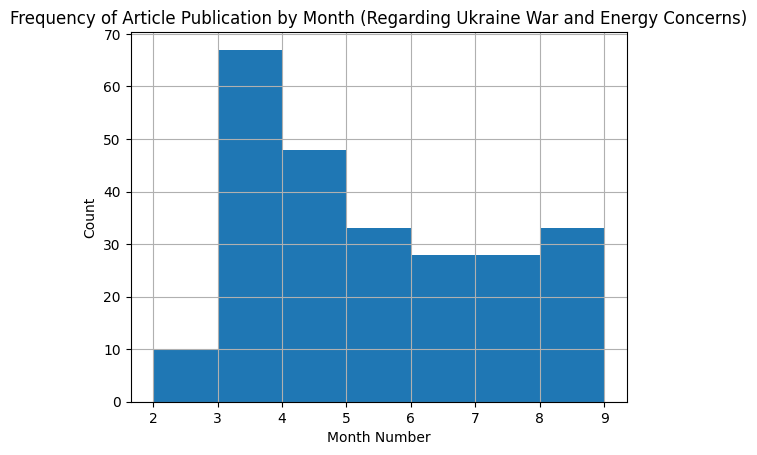

In [97]:
energy_keywords_frequency_hist = create_hist(combined_energy_keywords_df, "Month", [2, 3, 4, 5, 6, 7, 8, 9], 'Frequency of Article Publication by Month (Regarding Ukraine War and Energy Concerns)', 'Month Number', 'Count')

Interesting, spike in month 8. whys that?

In [98]:
energy_month_3_df = combined_energy_keywords_df.loc[(combined_energy_keywords_df['Month']==3)]
energy_month_6_df = combined_energy_keywords_df.loc[(combined_energy_keywords_df['Month']==8)]

# Look at just the web titles
print("Month 3:")
print()
for item in energy_month_3_df['Web Title']:
    print(item)
print()
print("Month 8:")
print()
for item in energy_month_6_df['Web Title']:
    print(item)

Month 3:

Germany could ration power if fuel standoff continues - as it happened
Germany close to gas rationing as it activates emergency fuel plan
‘Some reduction’ in bombardment of Kyiv, says UK – as it happened
Biden and allies vow to keep up Russia punishment for ‘brutal attacks in Ukraine’ – as it happened
Bank of England governor warns swings in commodity prices pose risk to market resilience – as it happened
Zelenskiy promises to work for new sanctions against Russia – as it happened
Institute for Study of War says Russians unable to secure Kyiv attack positions – as it happened
Biden in Poland for meetings on Ukraine refugee crisis – US politics as it happened
Ukraine war: Zelenskiy urges global protests ‘in the name of peace’ to mark month since invasion began
‘Energy or rent?’ Britons expect rising hardship after Sunak’s spring statement
Nuclear energy push is not powered by sense | Letters
Rishi Sunak lowers fuel duty by 5p and promises income tax cut
Russia-Ukraine war: wha

Can't seem to find a clear trend of common words shared in both months, how about looking over all results?

In [99]:
month_check = int(combined_energy_keywords_df['Month'].min())
# Look at just the web titles
while month_check <= int(combined_energy_keywords_df['Month'].max()):
    energy_keywords_month_result_df = combined_energy_keywords_df.loc[(combined_energy_keywords_df['Month']==month_check)]
    print(f"Month {month_check}:")
    for item in energy_keywords_month_result_df['Web Title']:
        print(item)
    month_check += 1
    print()

Month 2:
Morning mail: Russia faces unprecedented sanctions, worst flooding in history, IPCC warns on climate crisis
Russian central bank hikes rates and closes stock market as rouble crashes; oil and gas soar – as it happened
US inflation is at a 40-year high. Russia’s war will only make it worse
US fossil fuel industry leaps on Russia’s invasion of Ukraine to argue for more drilling
Oil jumps to $105, gas prices surge and global stocks tumble after Ukraine invasion – as it happened
Morrison condemns Moscow’s ‘brutal’ attack on neighbour – as it happened
The west stood back and watched in Syria – it must not do the same in Ukraine | Hamish de Bretton-Gordon
Scott Morrison speaks to Ukraine PM; 60 Covid deaths reported – as it happened
Oil prices hit seven-year highs close to $100 after Russia moves troops into Ukraine – as it happened
Morning mail: Australia welcomes international tourists, ceasefire attempt for Ukraine, Queen has Covid

Month 3:
Germany could ration power if fuel sta

Interesting, still no clear underlying common term/s, aside from russia, ukrain, and energy (i.e., the words we filtered for in the first place)

Next, lets look at the politicians. To do this, we first create histograms based on the Frequency of the mention of each politician in the data

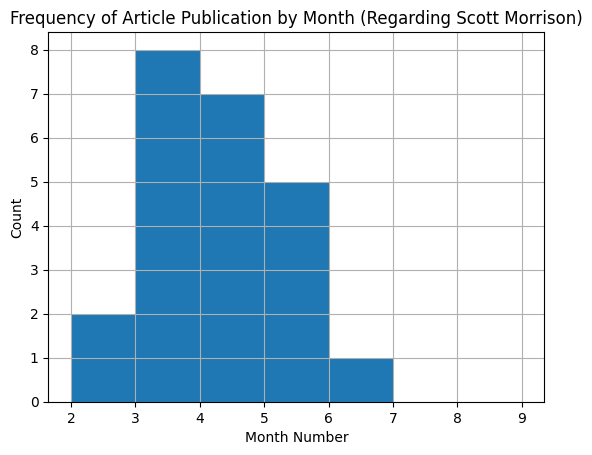

In [100]:
scomo_frequency_hist = create_hist(combined_political_scott_keywords_df, "Month", [2, 3, 4, 5, 6, 7, 8, 9], 'Frequency of Article Publication by Month (Regarding Scott Morrison)', 'Month Number', 'Count')

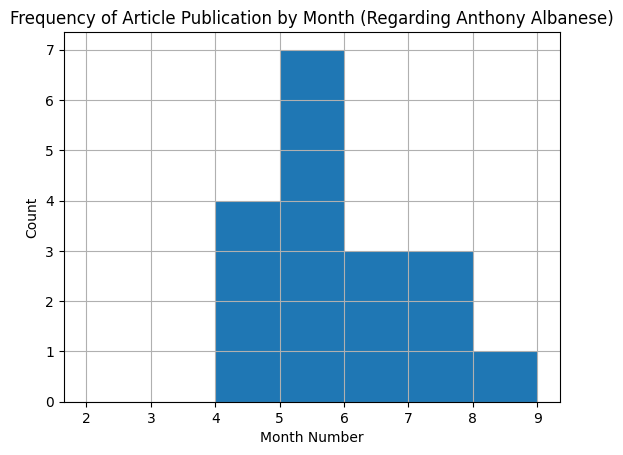

In [101]:
albo_frequency_hist = create_hist(combined_political_anthony_keywords_df, "Month", [2, 3, 4, 5, 6, 7, 8, 9], 'Frequency of Article Publication by Month (Regarding Anthony Albanese)', 'Month Number', 'Count')

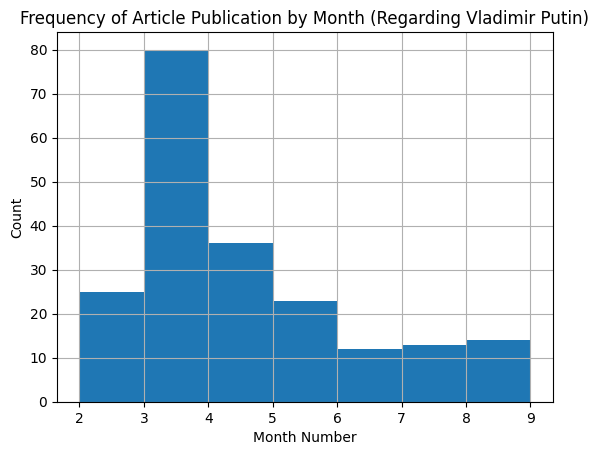

In [102]:
putin_frequency_hist = create_hist(combined_political_vladimir_keywords_df, "Month", [2, 3, 4, 5, 6, 7, 8, 9], 'Frequency of Article Publication by Month (Regarding Vladimir Putin)', 'Month Number', 'Count')

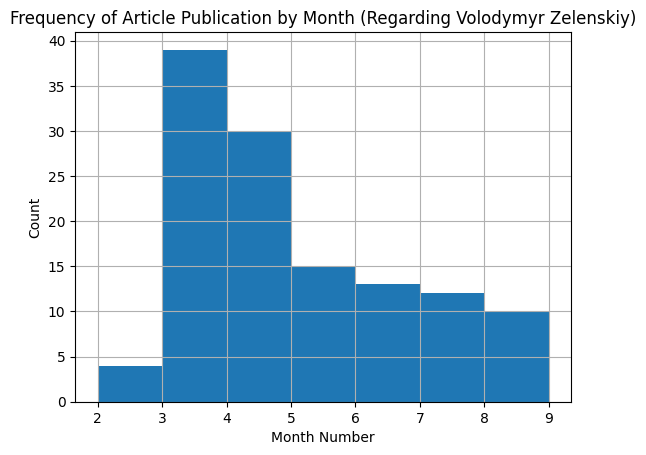

In [103]:
zelenskyy_frequency_hist = create_hist(combined_political_zelenskyy_keywords_df, "Month", [2, 3, 4, 5, 6, 7, 8, 9], 'Frequency of Article Publication by Month (Regarding Volodymyr Zelenskiy)', 'Month Number', 'Count')

Now we would like to view how Scott Morrison and Anthony Albanese pair up together, as they have opposing looking histograms. To do this, we do a similar process as before, but creating line graphs, not histograms

In [104]:
# Grab the frequency of article publication per politician, per month
scomo_frequency_df = count_generator(combined_political_scott_keywords_df, "Month")
albo_frequency_df = count_generator(combined_political_anthony_keywords_df, "Month")
putin_frequency_df = count_generator(combined_political_vladimir_keywords_df, "Month")
zelenskyy_frequency_df = count_generator(combined_political_zelenskyy_keywords_df, "Month")

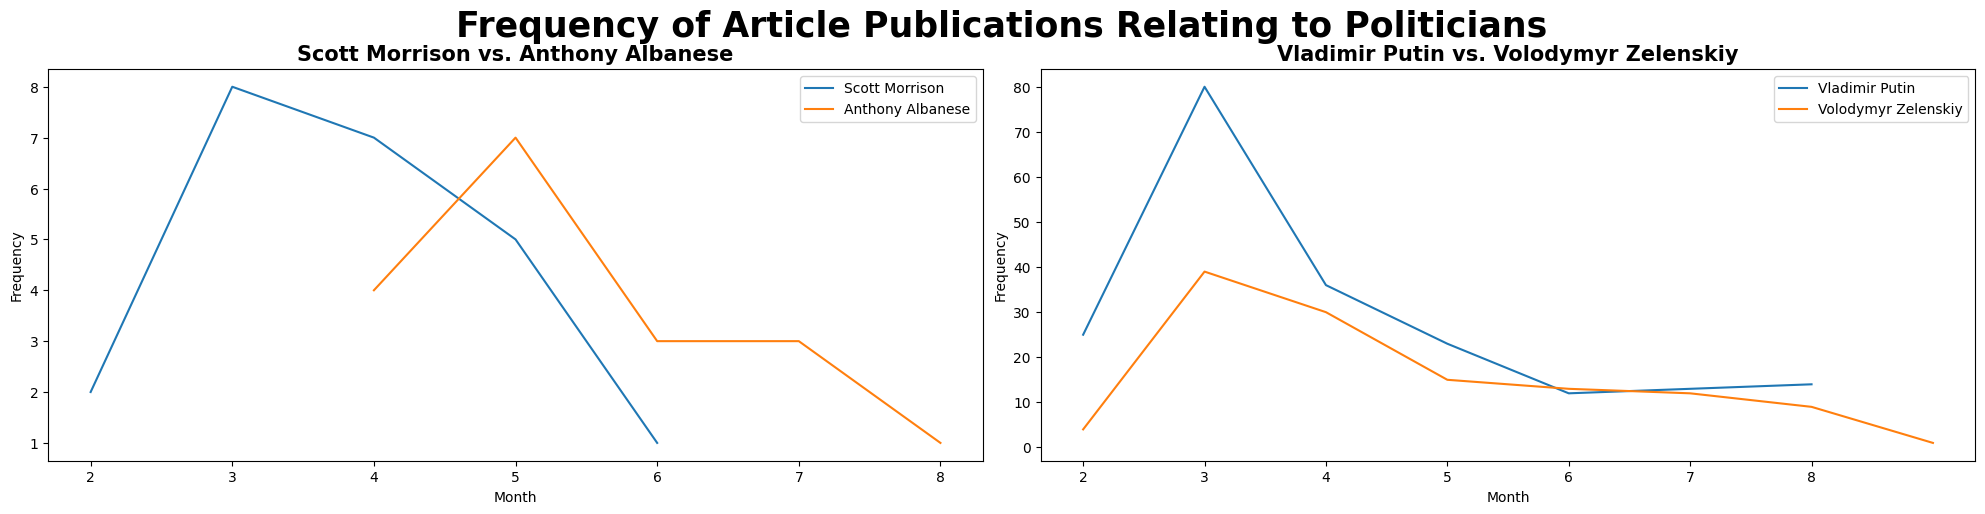

In [105]:
# Visualise the politicians
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle("Frequency of Article Publications Relating to Politicians", fontweight="bold", size=25)
fig.tight_layout(h_pad=20)

axs[0].set_title("Scott Morrison vs. Anthony Albanese", fontweight="bold", size=15)
scomo_frequency_df.plot('Month', 'Count', ax=axs[0], label="Scott Morrison", xticks=[2, 3, 4, 5, 6, 7, 8], xlabel="Month", ylabel="Frequency")
albo_frequency_df.plot('Month', 'Count', ax=axs[0], label="Anthony Albanese", xticks=[2, 3, 4, 5, 6, 7, 8], xlabel="Month", ylabel="Frequency")
axs[0].legend(loc='upper right')

axs[1].set_title("Vladimir Putin vs. Volodymyr Zelenskiy", fontweight="bold", size=15)
putin_frequency_df.plot('Month', 'Count', ax=axs[1], label="Vladimir Putin", xticks=[2, 3, 4, 5, 6, 7, 8], xlabel="Month", ylabel="Frequency")
zelenskyy_frequency_df.plot('Month', 'Count', ax=axs[1], label="Volodymyr Zelenskiy", xticks=[2, 3, 4, 5, 6, 7, 8], xlabel="Month", ylabel="Frequency")
axs[1].legend(loc='upper right')

Now a similar process, but for the 'Russia' and 'Prices' Data

<AxesSubplot:title={'center':'Frequency of Article Publications Relating to Russia'}, xlabel='Month', ylabel='Frequency'>

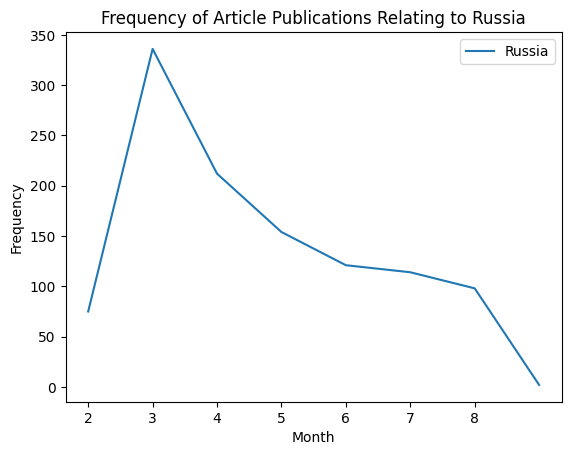

In [106]:
# Grab, and plot the frequency of article publication for articles containing the word 'Russia' per month
russia_frequency = count_generator(combined_russia_keywords_df, "Month")
russia_frequency.plot('Month', 'Count', xticks=[2, 3, 4, 5, 6, 7, 8], xlabel="Month", ylabel="Frequency", title="Frequency of Article Publications Relating to Russia", label="Russia")

<AxesSubplot:title={'center':'Frequency of Article Publications Relating to Price Fluctuations'}, xlabel='Month', ylabel='Frequency'>

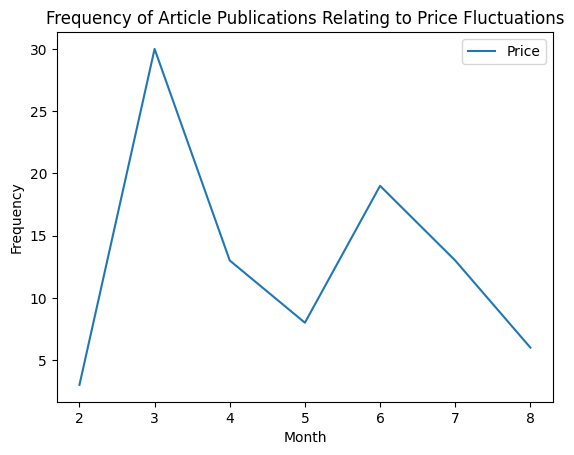

In [107]:
# Grab, and plot the frequency of article publication for articles containing the word 'Price' per month
price_frequency = count_generator(combined_price_keywords_df, "Month")
price_frequency.plot('Month', 'Count', xticks=[2, 3, 4, 5, 6, 7, 8], xlabel="Month", ylabel="Frequency", title="Frequency of Article Publications Relating to Price Fluctuations", label="Price")

Interesting spikes in Month 3 and 6 for price graph. Why is this the case?

In [108]:
# interesting spike in frequency in month 3 and 6 (for price graph)
price_month_3_df = combined_price_keywords_df.loc[(combined_price_keywords_df['Month']==3)]
price_month_6_df = combined_price_keywords_df.loc[(combined_price_keywords_df['Month']==6)]

# Look at just the web titles
print("Month 3:")
print()
for item in price_month_3_df['Web Title']:
    print(item)
print()
print("Month 6:")
print()
for item in price_month_6_df['Web Title']:
    print(item)

Month 3:

‘I know how much it hurts’: Biden to release US oil in bid to lower gas prices – as it happened
Motorists may wait weeks for lower petrol prices as retailers use up old stock
Biden announces ‘largest release of oil reserves’ in effort to curb gasoline prices
UK economy grows faster than expected; prices drop as US mulls big oil reserve release – as it happened
Egg farmers: UK supermarkets must raise price or we’ll go under
Oil prices fall after US ponders record-breaking release of crude reserves
Stock markets rally on Russia-Ukraine talks, oil prices dip – as it happened
Iceland reverts to palm oil ‘with regret’ as Ukraine war hits food prices
Bank of England governor warns swings in commodity prices pose risk to market resilience – as it happened
Cost of living crisis hitting economic outlook as firms hike prices – as it happened
Eugene Shvidler: oligarch pays high price for close ties to Abramovich
Next says prices to rise by 8% in autumn amid ‘chronic’ staff shortages
UK 

A large amount of the articles published in those two months are referring to fuel in some way...how many exactly?

In [109]:
# define the keywords
fuel_check_keywords = ["fuel", "gas", "petrol", "diesel", "oil"]
checked_price_keywords_search_results = []

# create the required dataframes
checked_price_keywords_df, checked_price_keywords_search_results = keyword_search(price_keywords_search_results, fuel_check_keywords, checked_price_keywords_search_results)

fuel_price_frequency = count_generator(checked_price_keywords_df, "Month")

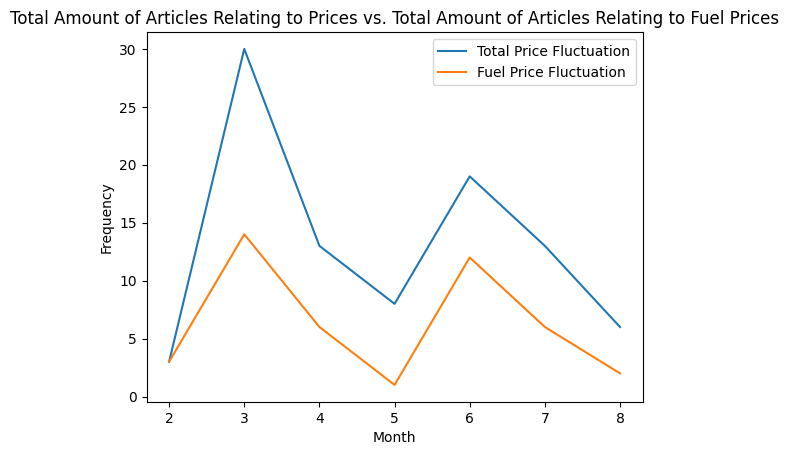

In [110]:
# Create a graph, make it appealing
x = [2, 3, 4, 5, 6, 7, 8]
default_x_ticks = range(len(x))
plt.plot(price_frequency['Count'], label="Total Price Fluctuation")
plt.plot(fuel_price_frequency['Count'], label="Fuel Price Fluctuation")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.title("Total Amount of Articles Relating to Prices vs. Total Amount of Articles Relating to Fuel Prices")
plt.xticks(default_x_ticks, x)
plt.legend(loc='upper right')
plt.show()

What % of the total prices articles are relating to fuel?

In [111]:
iteration_checker = 0
percentage_list = []
print("The percentage of fuel price articles compared to the total amount of 'price' articles each month is:")
while iteration_checker < len(fuel_price_frequency['Count']):
    percentage = round(fuel_price_frequency['Count'][iteration_checker] / price_frequency['Count'][iteration_checker] * 100, 2)
    percentage_list.append(percentage)
    print(f"Month {fuel_price_frequency['Month'][iteration_checker]}: {percentage}%")
    iteration_checker +=1
print()
print(f"The overall percentage is {round(sum(percentage_list) / len(percentage_list), 2)}%")

The percentage of fuel price articles compared to the total amount of 'price' articles each month is:
Month 2: 100.0%
Month 3: 46.67%
Month 4: 46.15%
Month 5: 12.5%
Month 6: 63.16%
Month 7: 46.15%
Month 8: 33.33%

The overall percentage is 49.71%


### 5. Insight

*Write your business insights drawn from the data analytics. Ensure that you clearly connect the business concern, the question, the analytics and the insights.*

The concern identified to our company by our client is a potential negative impact on consumer spending over the last six months. Our client suspects the cause of this impacted consumer spending to be resulting from the media reporting surrounding the war in Ukraine, global energy issues, global fuel issues, or any related topic.

To analyse the validity of these concerns, we use a variety of data. This data was sourced from the guardian API, at it is an internationally trusted and utilised news source and contains a large amount of articles on similarly numerous topics. We decided to focus on six main topics to identify any correlations. These topics were the war in Ukraine, global fuel issues, global energy issues, any mentions of Russia, any mentions of politicians (Australian, Russian, or Ukrainian), or any mentions of prices. The first three topics are self-explanatory, as they are directly what the client is concerned about. similarly, we are assuming that any article about Russia in the last six months can also be closely linked to the war in Ukraine, therefore this topic was also taken into consideration. Additionally, Australian, Russian, and Ukrainian politicians were analysed as there said could likely be a direct correlation between the portrayal of that politician (both positive or negative) and the overall perspective of that politicians supporter; therefore, potentially impacting their spending habits in certain areas. Depending on the results, a correlation between politicians and other topics could also be identified. Finally, the analysis of prices was conducted to try to determine any correlation to the previous topics, or any frequently occurring areas of concern.

What is the concern?
What data did we use?
How did we analyse it, what decisions and why?
What do the visualisations tell us?
What is the recommendation for the concern? What other information would be helpful? What doesn't the data tell us? Can we make inferences?

#### **The overall concern:** <br />
The concern identified to our company by our client is a potential negative impact on consumer spending over the last six months. Our client suspects the cause of this impacted consumer spending to be resulting from the media reporting surrounding the war in Ukraine, global energy issues, global fuel issues, or any related topic.

#### **What data was used:** <br />
To analyse the validity of these concerns, we use a variety of data. This data was sourced from the guardian API, at it is an internationally trusted and utilised news source and contains a large amount of articles on similarly numerous topics. We decided to focus on six main topics to identify any correlations. These topics were: <br />
1. the war in Ukraine<br />
2. global fuel issues<br />
3. global energy issues<br />
4. any mentions of Russia in the sourced articles<br />
5. any mentions of politicians (Australian, Russian, or Ukrainian) in the sourced articles<br />
6. any mentions of prices in the sourced articles.<br />


The first three topics are self-explanatory, as they are the main topics identified by the client. 

Similarly, we are assuming that any article about Russia in the last six months can also be closely linked to the war in Ukraine, therefore this topic was also taken into consideration. Additionally, Australian, Russian, and Ukrainian politicians were analysed as there said could likely be a direct correlation between the portrayal of that politician (both positive or negative) and the overall perspective of that politicians supporter; therefore, potentially impacting their spending habits in certain areas. The analysis of only Australian, Ukrainian, and Russian leaders is to reduce the scope of the data. Furthermore, both Scott Morrison and Anthony Albanese will be identified as the Australian election occurred during the main reporting period of the Ukraine War. Depending on the results, a correlation between politicians and other topics could also be identified. Finally, the analysis of prices was conducted to try to determine any correlation to the previous topics, or any frequently occurring areas of concern. It should be mentioned that assumption was made that any mention of prices in articles regarding the Ukraine war, fuel issues, or energy issues will be negative as the media will likely be trying to identify a relationship between the negative events of the Ukraine war, and any price fluctuations, or alterations negatively impacting society. <br />

Additionally, the last three topics will be analysed using the data pulled direct from the API, so they should be directly relevant to the overall topics in question.


#### **How the data was analysed:** <br />
The analysis performed contained three main steps. The first step involved identifying the overall topics (the war in Ukraine, global fuel issues, and global energy issues), and retrieving this data from the guardian API. Once all the data was retrieved, it was then placed into a data frame for further analysis to occur. The fervent use of data frames achieves three main goals, being permanent data storage, the ability to access the data multiple times easily, and a visually appealing medium of data viewing. <br />

The second step of the process involved analysing the data retrieved to identify any baseline trends, as well as using the data obtained in the first step to identify the presence of the latter three topics identified (mention of Russia, politicians, or prices). This was achieved by searching the titles of the articles retrieved from the API using keywords, then creating new data frames each time a group of keywords is searched. Individualising the output results of each group of keywords allows for an easier time analysing each output specifically, and still achieves the main three goals identified previously. An example of this would be regarding politicians. When analysing the presence of the mention of politicians in the articles obtained from the API, four new data frames were created (one each for Vladimir Putin, Scott Morrison, Anthony Albanese, and Volodymyr Zelenskyy). This allows for the identification of any potential correlations for each politician specifically, then further visualise the output data for each politician comparatively. The same process was completed for identify presence of Russia, and the word ‘price’ in the original data. <br />

The final step of analysis involved visualising the data. two types of grass for used come out being histograms, and line graphs. Histograms are commonly used to identify occurrences of data, therefore in this case they were used to graphically represent the frequency of the publication of articles mentioning Scott Morrison, Anthony Albanese, Vladimir Putin, or Volodymyr Zelenskyy (One histogram was created per politician). From there, bar graphs were created for each politician, with Scott Morrison and Anthony Albanese being plotted on the same graph. As mentioned previously, the Australian election occurred during the primary reporting period of the Ukraine war, therefore it can be assumed that once Anthony Albanese was voted into parliament, any articles pertaining to the Australian leader would mention Anthony Albanese as opposed to Scott Morrison. Finally, bar graphs were created for articles mentioning Russia, and articles mentioning the word price.

#### **What do the visualtions tell us:** <br />
The first data that was analysed was the direct correlation between articles about the Ukraine war, and energy or fuel concerns. In the histogram, it can be observed that the frequency spiked in March, then decreased until it plateaued in June, until August in which it started increasing again. To try and identify any underlying trend existing in both March and August articles, manual analysis was conducted upon the titles of said articles. However, there existed no commonly mentioned topic aside from the words Ukraine, fuel, and energy, which where the keywords used to filter the overall data set in the first place. From there, manual analysis was conducted on the article titles from every month, however similarly there existed no commonly mentioned topic. For now, it was concluded that this is a phantom spike (a spike in article publication frequency for no single discernible reason).

The next data set analysed was the data pertaining to the politicians. Firstly, as assumed, following the Australian election, articles mentioning Scott Morrison quickly declined. However articles mentioning Anthony Albanese quickly increased. The obvious reasoning for this would be the necessity of mentioning the Australian Prime Minister, as opposed to a specific member of parliament. Furthermore, as seen in the graphs made for both Vladimir Putin, and Volodymir Zelenskyy, the frequency of article publication spiked in March, then quickly declined in the proceeding months. This same relationship can mostly be seen in the bar graph containing the frequency of article publications relating to Russia, Scott Morrison, and Anthony Albanese.

However, an interesting relationship can be identified in the fifth and sixth months in both the Vladimir Putin graph, and the Scott Morrison versus Anthony Albanese graph. As can be seen in the latter, the frequency of articles published spiked in the 5th month (specifically mentioning Anthony Albanese). However, as seen in the former, the frequency of articles published mentioning Vladimir Putin constantly increased from the 6th month onwards, directly opposing the previous trend identified. This new trend, coupled with the fact that articles mentioning Russia only continually declined from the spike in March, implies that any articles about the Ukrainian war, fuel or energy issues from May onwards are likely regarding the decisions of the Australian or the Russian leader, as opposed to the decisions made by Russia in its entirety. Therefore, it is likely that from may onwards, criticism regarding these leaders occurs more frequently in news articles then before. As mentioned previously, any portrayal of a politician in the media (both positive and negative) should have a directly correlating impact on said politicians supporters, potentially impacting their spending on any recently mentioned areas. For example, any criticism of Vladimir Putin (as the leader of Russia), could result in any reader of said article who opposes Vladimir Putin lowering their spending on Russian related products. This logic can then be applied to the graphs regarding Volodymyr Zelenskyy, and Scott Morrison versus Anthony Albanese.

When looking at the graph containing the frequency of article publications relating to price fluctuations, an interesting relationship is present. Obviously, there is a large spike in March which lines up with every other graph as there is simply a larger number of articles published regarding the Ukraine war in March compared to any other month. However, it can be seen that there is a second spike in June where it then declined again in proceeding months. Although this trend is somewhat similar to what was observed in the Vladimir Putin graph, the logic cannot be directly applied here. To try and find the cause of this spike in June, manual analysis of all the titles of articles published in both March and June was conducted to define a potential underlying trend. From this analysis, it was found that a large number of articles published mentioned fuel in the title (the keywords used were fuel, oil, petrol, diesel, and gas). When this search was expanded to every month, and graphed together with all the articles regarding price, a very clear relationship occurs whereby both data sets contain the exact same trend line (spiking in March and June, decreasing in all other months). Additionally, when looking at the percentage of articles mentioning fuel in some form, it's shown that June contained a higher percentage of articles compared to March. This trend could explain multiple other relationships identified. 

Firstly, as 49% of the articles regarding price fluctuations also mentioned fuel (of some form) in the title, it can be concluded that the primary area of impacted consumer spending is fuel. This trend identified makes perfect sense when considering that both Ukraine and Russia are large international exporters of both fuel and oil. Therefore, any conflict between the two countries, or any actions by their leaders (or the country in their entirety) would directly affect the international supply of fuel, leading to a larger media presence of this topic.

Secondly, as Russia is a common exporter of fuel and oil, any actions of Vladimir Putin which negatively affect the fuel prices would both increase the frequency of articles mentioning fuel prices; and create a surgency of articles mentioning Vladimir Putin specifically, thereby creating a snowball effect of negative portrayal of Vladimir Putin. This would then explain the sudden increase of articles mentioning Vladimir Putin from June onwards. This relationship can be brought back to the previously identified logic, where the constant portrayal of Vladimir Putin (now with relation to affected fuel prices) would heavily impact consumer spending on Russian products.

With this being said, it is not clear whether the June spike of ‘fuel price’ articles is directly related to Vladimir Putin, or an external factor. However, since the original dataset is articles pertaining to the Ukraine war, fuel, or energy issues, this external factor must in some form be related to these topics. Additionally, this would mean that the sudden increase in Vladimir Putin related articles would similarly be caused by an external factor.

No matter which reason is correct, this should explain the ‘phantom’ spike observed in the first histogram, where it is likely that an event occurring around June caused a snowball effect.


#### **Recommendations for Concern:** <br />
In conclusion, as is identified previously, the main area of consumer spending impacted from the Ukraine war, or global fuel or energy issues, is fuel and oil. Additionally, there has recently been a surgency of media representation of Vladimir Putin. Therefore, it is recommended to avoid any affiliation or mention of Vladimir Putin, Russia, or Ukraine to avoid any second hand/flow off effect on consumer spending. This will also allow your business to remain neutral, of also avoiding any potential negative impact sourced from the political opinions of your consumers. <br />

There is a large amounts of information omitted from the collected data that would prove useful in reaching further, or more refined conclusions. Firstly, information about other common areas of consumer spending put in turn help identify or conclude the cause of the ‘phantom spike’ seen in the first histogram. Furthermore, obtaining data to help confirm the reasoning of the number of articles regarding Vladimir Putin suddenly increasing from June onwards would allow a more well-reasoned insight on this topic. This could then lead to a more accurate conclusion. Finally, the total number of articles mentioning either of the 2 Australian prime ministers in the reporting period is noticeably low. Obtaining more data on either of the two mentioned prime ministers would also assist in coming to a clearer and more accurate conclusion on the overall business concern. <br />

As mentioned, the data does not bring to light the effect on other areas of consumer spending, due to the sheer lack of data on these topics. However, despite this absence, it is still clear that fuel is the most heavily impacted area. Despite the assumptions mentioned previously (primarily being any mention of politicians is directly pertaining to the Ukraine war, and the sudden increase of mentions of Vladimir Putin is a direct result of an action), it is not completely clear if these assumptions are well founded. For example, there is potential that the increase in frequency of Vladimir Putin (from June onwards) isn't a result of an action pertaining to the war, but the articles where he is mentioned from June onwards are simply mentioning the Ukraine war in conjunction comparatively. An example of this could be an article simply mentioning a minor action taken by Vladimir Putin, unrelated to the Ukraine war (however specifying that is action took place after the events of the Ukraine War). An article of this nature would not have any effect on consumer spending as it is unrelated to any previously mentioned topic. In order to identify any articles of this nature, deep analysis would have to be performed on every article to identify said article’s overall point. However, due to the likelihood of this event being quiet low, it can be reasonably assumed that this is not the case.
